# Intersection Interactions

## CMSE 202 Final Project

#### Denis, William, Gabby, and Landon

#### 4/22/23

In [1]:
# necessary imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from random import choice
import time
from IPython.display import display, clear_output
import math

## Questions

- For what amount of traffic does a stoplight become more efficient than a 4-way stop?
- Can we use a model to determine the ideal intersection for given traffic?
- To what extent can contemporary modeling software represent driving interactions?


## Set-up and Measurements

In this project, we use an agent based model to model traffic interactions. An intersection object will serve as each simulation's environment, which will hold and interact with vehicle objects. Each intersection object will be visually modeled on a graph on the interval -10<x<10 and -10<y<10. We use a few reasonable assumptions to simplify, yet realize our model.

1. Scale: 1 unit = 5 meters
2. Road width: 10m = 2u
3. Average max speed: 20 m/s = 4u/s (~44.7mph)
4. Timestep = .1 second
5. Average max speed = .4 units/timestep
6. Acceleration = 3 m/s/s = .006 units/timestep/timestep

## Vehicle Path Equations

This code approach tracks and progresses the movement of vehicles using parametic equations. This way, instead of using imprecise velocity update equations, the vehicles will stay exactly on one path and all that has to be tracked is the distance along this path. It is important to note that the variable "t" is used NOT to represent time, but rather represents the distance the vehicle is along its path.

.5 and -.5 are used to place vehicles in the center of road lanes

t-10 -> go from left to right/down to up in the x or y direction

10-t -> go from right to left/up to down in the x or y direction


In [7]:
'''Vehicle Path Equations'''

'''Inputs a single coordinate along a 
vehicle's path and returns parametrized 
x and y coordinates'''

# Straight Paths
def down_up(t):
    return .5, t-10

def left_right(t):
    return t-10, -.5

def up_down(t):
    return -.5, 10-t

def right_left(t):
    return 10-t, .5

# Right Turns
def down_right(t):
    if t <= 9:
        return .5, -10+t
    elif t < 9+np.pi/4:
        return 1 - .5*np.cos(2*t-18), -1 + .5*np.sin(2*t-18)
    else:
        return t-8-np.pi/4, -.5
    
def left_down(t):
    if t <= 9:
        return -10+t, -.5
    elif t < 9+np.pi/4:
        return -1 + .5*np.sin(2*t-18), -1 + .5*np.cos(2*t-18)
    else:
        return -.5, 8+np.pi/4-t
    
def up_left(t):
    if t <= 9:
        return -.5, 10-t
    elif t < 9+np.pi/4:
        return -1 + .5*np.cos(2*t-18), 1 - .5*np.sin(2*t-18)
    else:
        return 8+np.pi/4-t, .5
    
def right_up(t):
    if t <= 9:
        return 10-t, .5
    elif t < 9+np.pi/4:
        return 1 - .5*np.sin(2*t-18), 1 - .5*np.cos(2*t-18)
    else:
        return .5, t-8-np.pi/4
    
# Left Turns
def down_left(t):
    if t <= 9:
        return .5, -10+t
    elif t < 9+3*np.pi/4:
        return -1 + 1.5*np.cos(2*(t-9)/3), -1 + 1.5*np.sin(2*(t-9)/3)
    else:
        return 8+3*np.pi/4 - t, .5
    
def left_up(t):
    if t <= 9:
        return -10+t, -.5
    elif t < 9+3*np.pi/4:
        return -1 + 1.5*np.sin(2*(t-9)/3), 1 - 1.5*np.cos(2*(t-9)/3)
    else:
        return .5, t-8-3*np.pi/4
    
def up_right(t):
    if t <= 9:
        return -.5, 10-t
    elif t < 9+3*np.pi/4:
        return 1 - 1.5*np.cos(2*(t-9)/3), 1 - 1.5*np.sin(2*(t-9)/3)
    else:
        return -8-3*np.pi/4 + t, -.5
    
def right_down(t):
    if t <= 9:
        return 10-t, .5
    elif t < 9+3*np.pi/4:
        return 1 - 1.5*np.sin(2*(t-9)/3), -1 + 1.5*np.cos(2*(t-9)/3)
    else:
        return -.5, -t+8+3*np.pi/4


## Vehicle Class

Each vehicle in the simulation will come from a vehicle object which holds important information. The vehicle class is responsible for updating a vehicles position based on its speed, however, the bulk of the cars driving logic will be handled by the environment (this will make it easier to adjust logic for stopsign and stoplight subclasses).

In [8]:
class Vehicle():
    '''General vehicle class'''
    
    def __init__(self, maxspeed=.4, loc='down', dest='right', random=False):
        '''
            Defines the vehicle
            
            time - float: simulated time vehicle has spent in intersection (sec)
            t - float: distance along the path
            stop - boolean: if True, the vehicle will choose to stop when approaching an intersection (handled by Intersection Class)
            accelertaion - float: defualt acceleration of vehicle (units/timestep/timestep)
            start - string: location on intersection the vehicle will start ("up", "right", "down", "left")
            destination - string: location the vehicle is heading to ("up", "right", "down", "left")
            equation - function: parameterized path equation of vehicle
            position - tuple: x and y coordinates of vehicle
            maxspeed - float: top speed vehicle will travel (units/timestep)
            speed - float: current speed of vehicle (units/timestep)
        '''
        self.time = 0
        self.t = 0   
        self.stop = True
        self.acceleration = .006
        if random:
            # randomly selects spawn location and destination
            options = ["up", "right", "down", "left"]
            self.start = choice(options)
            options.remove(self.start) 
            self.destination = choice(options)
            self.equation = eval(self.start+"_"+self.destination) # assigns appriopriate path equation 
            self.position = self.equation(0)
            self.maxspeed = maxspeed + np.random.randn()*.05 # adds random variation based on normal distribution
            self.speed = self.maxspeed 

        else:
            self.start = loc
            self.destination = dest
            self.equation = eval(loc+"_"+dest)
            self.position = self.equation(0)
            self.maxspeed = maxspeed
            self.speed = maxspeed

    def move(self):
        '''Updates position and t based on speed'''
        self.t += self.speed
        self.position = self.equation(self.t)
        self.time += .1
    
    def set_pos(self, pos):
        '''Sets position of vehicle'''
        self.position = pos
        
    def get_pos(self):
        '''Gets position of vehicle'''
        return self.position
    
    def set_t(self, t):
        '''Sets t of vehicle'''
        self.t = t
        
    def get_t(self):
        '''Gets t of vehicle'''
        return self.t
    
    def set_stop(self, stop):
        '''Sets stop value of vehicle'''
        self.stop = stop
        
    def get_stop(self):
        '''Gets stop value of vehicle'''
        return self.stop
    
    def set_speed(self, s):
        '''Sets speed of vehicle'''
        self.speed = s
        
    def get_speed(self):
        '''Gets speed of vehicle'''
        return self.speed
    
    def set_maxspeed(self, s):
        '''Sets max speed of vehicle'''
        self.maxspeed = s
        
    def get_maxspeed(self):
        '''Gets max speed of vehicle'''
        return self.maxspeed
    
    def get_acceleration(self):
        '''Gets acceleration of vehicle'''
        return self.acceleration
    
    def set_dest(self, dest):
        '''Sets destination of vehicle'''
        self.destination = dest
    
    def get_dest(self):
        '''Gets destination of vehicle'''
        return self.destination
    
    def get_time(self):
        '''Gets time of vehicle'''
        return self.time
    
    def get_start(self):
        '''Gets starting location of vehicle'''
        return self.start

    def get_loc(self):
        '''Returns part of the intersection the vehicle is in'''
        x, y = self.position 
        if y > 1:
            return ('up', 0)
        elif x > 1:
            return ('right', 1)
        elif y < -1:
            return ('down', 2)
        elif x < -1:
            return ('left', 3)
        else:
            return ('center', 4)

## Intersection Class:

The general intersection class mostly handles the display, animatation, and simulation features. 

In [9]:
class Intersection():
    '''General intersection class'''
    
    def __init__(self, n=0):
        '''
            Defines the intersection
        
            vehicles - list: stores all vehicle objects currently in the intersection
        '''
        self.vehicles = []
        for i in range(n):
            self.vehicles.append(Vehicle(random=True))
            
    def add_vehicle(self, vehicle):
        '''Adds one vehicle to the intersection'''
        self.vehicles.append(vehicle)
        
    def add(self, vehicle):
        '''Adds one vehicle to the intersection'''
        self.vehicles.append(vehicle)
        
    def get_vehicles(self):
        '''Returns list of vehicles'''
        return self.vehicles
    
    def show(self):
        '''Graphs a static visual of the intersection, roads, and vehicles'''
        
        # draws road
        plt.gca().add_patch(plt.Rectangle((-10,-1), 20, 2, fc='grey'))
        plt.gca().add_patch(plt.Rectangle((-1,-10), 2, 20, fc='grey'))
        
        plt.gca().add_patch(plt.Rectangle((-10,-10), 9, 9, fc='green', ec='black'))
        plt.gca().add_patch(plt.Rectangle((1,-10), 9, 9, fc='green', ec='black'))
        plt.gca().add_patch(plt.Rectangle((-10,1), 9, 9, fc='green', ec='black'))
        plt.gca().add_patch(plt.Rectangle((1,1), 9, 9, fc='green', ec='black'))
        
        plt.gca().add_patch(plt.Rectangle((-9,-.0625), 1.5, .125, fc='yellow'))
        plt.gca().add_patch(plt.Rectangle((-5,-.0625), 1.5, .125, fc='yellow'))
        
        plt.gca().add_patch(plt.Rectangle((7.5,-.0625), 1.5, .125, fc='yellow'))
        plt.gca().add_patch(plt.Rectangle((3.5,-.0625), 1.5, .125, fc='yellow'))
        
        plt.gca().add_patch(plt.Rectangle((-.0625, -9), .125, 1.5, fc='yellow'))
        plt.gca().add_patch(plt.Rectangle((-.0625, -5), .125, 1.5, fc='yellow'))
        
        plt.gca().add_patch(plt.Rectangle((-.0625, 7.5), .125, 1.5, fc='yellow'))
        plt.gca().add_patch(plt.Rectangle((-.0625, 3.5), .125, 1.5, fc='yellow'))
        
        # draws vehicles
        for v in self.vehicles:
            x,y = v.get_pos()
            plt.plot(x, y, 'rs', markersize=15, markeredgecolor='black') 
        
        # limits plot to 20x20 area
        plt.xlim([-10, 10])
        plt.ylim([-10, 10])
        
        # removes tick marks
        plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False,
                labelbottom=False, labelleft=False)
    
    def timestep(self):
        '''Advances the vehicles generally for all intersections'''
        for v in self.vehicles:
            v.move() # updates the vehicle's position
            if v.get_t() > 21:
                self.vehicles.remove(v)
    
    def animate(self, n=1, visual=True):
        '''Loops over timesteps while displaying snapshots'''
        if visual:
            fig = plt.figure(figsize=(10,10))
            
            for i in range(n):

                # displays
                self.show()
                clear_output(wait=True)
                display(fig)
                fig.clear()

                # advances simulation
                time = self.timestep()

            plt.close()
        else:
            time = self.timestep()
        
        return time
    
    def simulate(self, n=500, spawn_chance=.02, display=True):
        '''simulates traffic using animate while spawning vehicles'''
        times_df = pd.DataFrame({"Start": [], "Dest": [], "Time": []})
        for i in range(n):
            freq = int(1/spawn_chance)
            if i % freq == 0:
                self.add(Vehicle(random=True))
            time = self.animate(visual=display)
            if time != None:
                times_df.loc[len(times_df.index)] = time
        return times_df, len(self.vehicles)
            

## Stopsign Subclass

The stopsign is an extension to the intersection class to simulate a 4-way stop.

In [57]:
class Stopsign(Intersection):    
    '''Subclass of Intersection that carries behavior of the 4-way stop'''
    
    def __init__(self, n=0):
        '''
            Defines Stopsign object
        
            busy - boolean: stores whether a vehicle is passing through the middle of the intersection 
        '''
        super().__init__(n)
        self.busy = False
        
    def show(self):
        '''Plots current state of intersection'''   
        super().show()
        
        # adds a decorative stopsign
        plt.gca().add_patch(plt.Rectangle((2.45, 1), .1, 1, fc='black'))
        plt.gca().add_patch(plt.Polygon(
            np.array([[2.293,2], [2,2.293], [2,2.707], [2.293, 3], [2.707, 3], [3,2.707], [3,2.293], [2.707, 2]]), 
            closed=True, fc='red', ec='black'))
        
    
    def timestep(self):
        '''Includes unique behavior of 4-way stop'''
                
        time_output = None # used to return vehicle data 
        
        # progresses the occupation status of the center of the intersection
        if self.busy == True:
            self.busy = "inter"
        elif self.busy == "inter":
            self.busy = False

        for v in self.vehicles:
            
            # creates temporary varibales for easy use
            pos = v.get_pos()
            t = v.get_t()
            speed = v.get_speed()
            maxspeed = v.get_maxspeed()

            # braking for stop sign
            if t > 4.5 and t < 8.2:
                v.set_speed((8.5-t)*maxspeed/4)
                
            # stopped or accelerating
            elif t >= 8.2 and (abs(pos[0])<1.8 and abs(pos[1])<1.8):
                if speed == 0 and self.busy == False:
                    v.set_stop(False)
                if v.get_stop():
                    v.set_speed(0)
                else:
                    self.busy = True
                    v.set_speed(speed+v.get_acceleration())
            
            # max speed driving
            elif abs(pos[0])>3.5 or abs(pos[1])>3.5:       
                v.set_speed(maxspeed)
                        
            # braking for vehicle ahead
            others = self.vehicles[:]
            others.remove(v)
            for c in others:
                # if on same axis, close together, and behind the other vehicle, slow down
                if (c.get_pos()[0]==pos[0] or c.get_pos()[1]==pos[1]) and (math.dist(c.get_pos(),pos)<4) and (t<c.get_t()):
                    new_speed = (math.dist(c.get_pos(),pos)-1)*maxspeed/3
                    if new_speed < v.get_speed():
                        v.set_speed(new_speed)
            
            # limits speeds to reasonable values
            if v.get_speed()>maxspeed:
                v.set_speed(maxspeed)
            if v.get_speed()<0:
                v.set_speed(0)
                
            v.move() # updates the vehicle's position

            # if a vehicle reaches its destination, remove it from the simulation and record its data
            if v.get_t() > 21:
                time_output = [v.get_start(), v.get_dest(), v.get_time()]
                self.vehicles.remove(v)
                
        return time_output
            

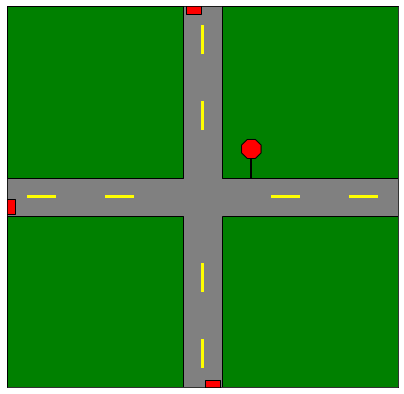

In [6]:
# Show image
road = Stopsign(3)
plt.figure(figsize=(7,7))
road.show()

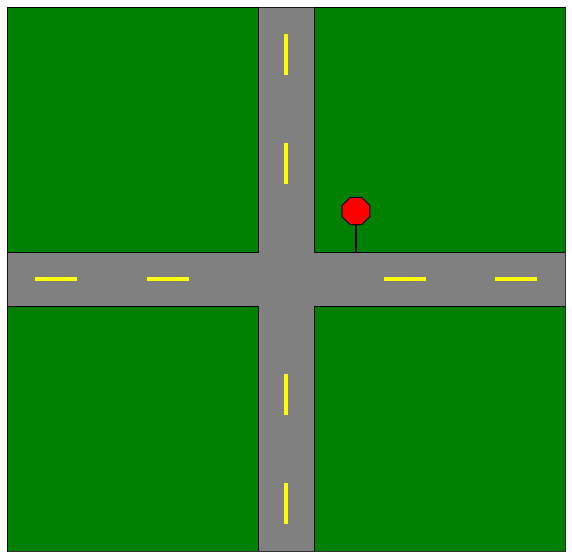

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [18]:
# Simulate two cars
road = Stopsign()
road.add_vehicle(Vehicle(loc='down', dest='left', random=False))
road.animate(30)
road.add_vehicle(Vehicle(loc='right', dest='up', random=False))
road.animate(260)

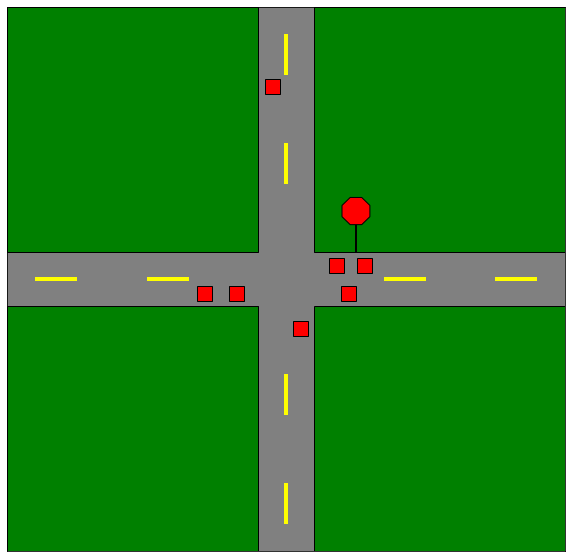

KeyboardInterrupt: 

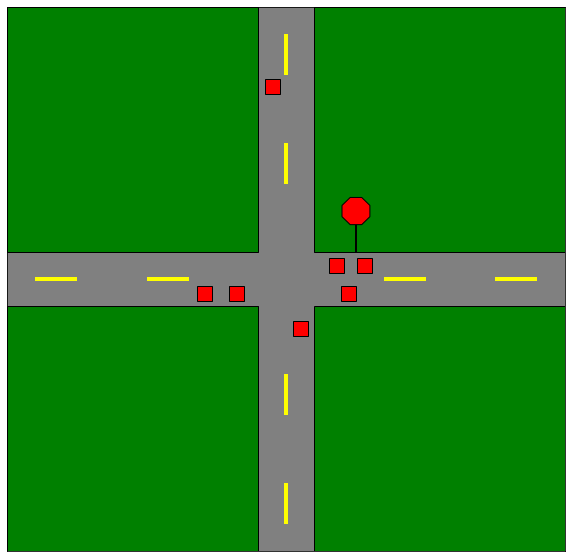

In [24]:
# Simulate traffic
road = Stopsign()
road.simulate(n=2000, spawn_chance=.04, display=True)

## Stoplight Subclass

The stoplight is an extension to the intersection class to simulate a simple traffic light.

In [11]:
class Stoplight(Intersection):    
    '''Subclass of Intersection that carries behavior of the stoplight'''
    
    def __init__(self, n=0, cycle_time=100, cur_time=0):
        '''
            Defines Stoplight object
            
            light - list: tracks status of each light (indicies correspond to up, right, down, then left)
                (0 is red, 1 is green, 2 is yellow)
            cycle_time - int: number of timesteps a red light will stay on
            cur_time - int: current timestep in relation to the cycle
        '''
        super().__init__(n)
        self.light = [1, 0, 1 ,0]
        self.cycle_time = cycle_time
        self.cur_time = cur_time
    
    def show(self):
        '''Displays current status of stoplight'''
        super().show()
        colors = ['red', 'lime', 'yellow']
        
        # adds visual representation of stoplight
        plt.gca().add_patch(plt.Circle((-1.7, 3), .5, fc=colors[self.light[0]]))
        plt.gca().add_patch(plt.Circle((3, 1.7), .5, fc=colors[self.light[1]]))
        plt.gca().add_patch(plt.Circle((1.7, -3), .5, fc=colors[self.light[2]]))
        plt.gca().add_patch(plt.Circle((-3, -1.7), .5, fc=colors[self.light[3]]))

    def timestep(self):
        '''Includes unique behavior of stoplight'''
        
        time_output = None # used to return vehicle data 
        
        # update stoplight
        if self.cycle_time-self.cur_time == 30:
            for i, light in enumerate(self.light):
                if light == 1:
                    self.light[i] = 2
            self.cur_time += 1
        if self.cycle_time-self.cur_time == 0:
            for i, light in enumerate(self.light):
                if light == 2:
                    self.light[i] = 0
                elif light == 0:
                    self.light[i] = 1
            self.cur_time -= self.cycle_time-1
        else:
            self.cur_time += 1
        
        # update vehicles 
        for v in self.vehicles:

            loc = v.get_loc()
            start = {"up":0, "right":1, "down":2, "left":3}[v.get_start()]
            dest = {"up":0, "right":1, "down":2, "left":3}[v.get_dest()]
            pos = v.get_pos()
            t = v.get_t()
            speed = v.get_speed()
            maxspeed = v.get_maxspeed()
            
            v.set_speed(speed+v.get_acceleration())
            
            # brake zone
            if t > 4.5 and t < 8.2:
                # braking for yellow and red light
                if self.light[loc[1]] == 0 or self.light[loc[1]] == 2:
                    v.set_speed((8.5-t)*maxspeed/4)
            
            # full stop
            if (t >= 8.2 and  t < 9)and (speed<maxspeed and (self.light[start] != 1)):
                    v.set_speed(0)  
            
            # turns slower
            if ((abs(pos[0])<1.8 and abs(pos[1])<1.8) and (abs(start-dest) == 1 or abs(start-dest) == 3)) and (speed>.5*maxspeed):
                v.set_speed(.5*maxspeed)
            
            # turn left yield
            if (start-dest == -1 or start-dest == 3) and (t>9 and t<(9+3*np.pi/4)):
                others = self.vehicles[:]
                others.remove(v)
                for c in others:
                    c_t = c.get_t()
                    c_start = {"up":0, "right":1, "down":2, "left":3}[c.get_start()]
                    c_dest = {"up":0, "right":1, "down":2, "left":3}[c.get_dest()]
                    # if they are coming from other side, not turning left, and within range
                    if (abs(c_start-start)==2) and (c_t>(4*t-28) and c_t<10):
                        if (c_start-c_dest == -1 or c_start-c_dest == 3):
                            pass
                        else:
                            v.set_speed(0)

            # braking for vehicle
            others = self.vehicles[:]
            others.remove(v)
            for c in others:
                c_start = {"up":0, "right":1, "down":2, "left":3}[c.get_start()]
                c_dest = {"up":0, "right":1, "down":2, "left":3}[c.get_dest()]
                # if on same axis, close together, and behind the other vehicle, slow down
                if (c_start==start or c_dest==dest) and (math.dist(c.get_pos(),pos)<4) and (t<c.get_t()):
                    new_speed = (math.dist(c.get_pos(),pos)-1)*maxspeed/3
                    if new_speed < v.get_speed():
                        v.set_speed(new_speed)
            
            # limits speeds to reasonable values
            if v.get_speed()>maxspeed:
                v.set_speed(maxspeed)
            if v.get_speed()<0:
                v.set_speed(0)
                
            v.move() # updates the vehicle's position
            
             # if a vehicle reaches its destination, remove it from the simulation and record its data
            if v.get_t() > 21:
                time_output = [v.get_start(), v.get_dest(), v.get_time()]
                self.vehicles.remove(v)

        return time_output

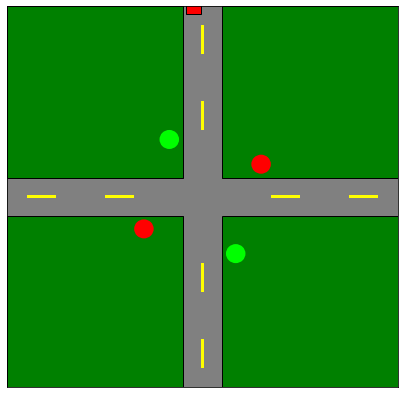

In [12]:
# Show image
road = Stoplight(1)
plt.figure(figsize=(7,7))
road.show()

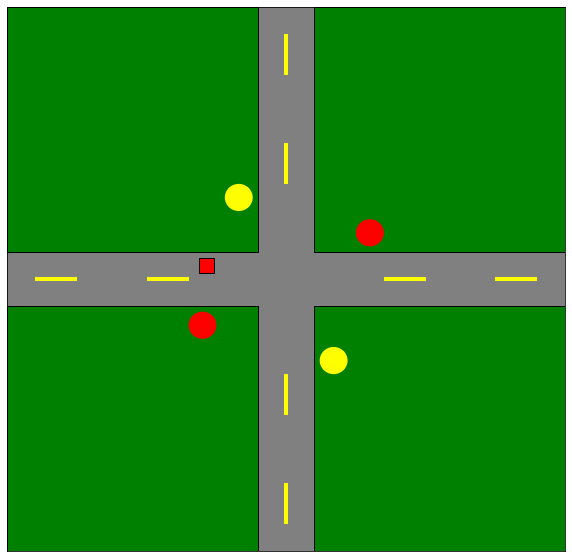

In [13]:
# Simulate two cars
road = Stoplight()
road.add_vehicle(Vehicle(maxspeed=.1, loc='down', dest='left', random=False))
road.animate(30)
road.add_vehicle(Vehicle(maxspeed=.1, loc='right', dest='up', random=False))
road.animate(260)

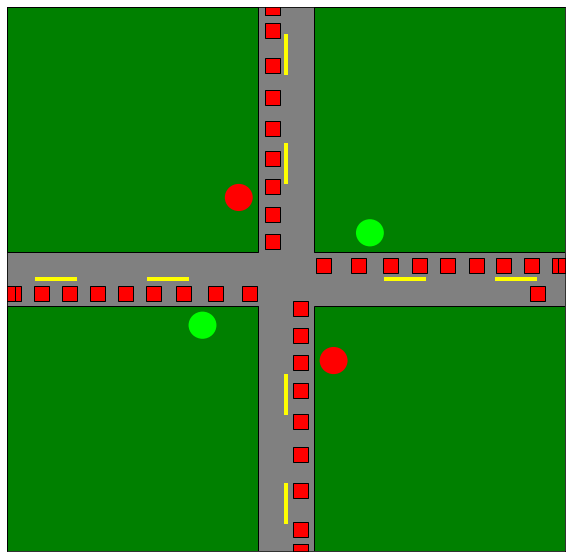

KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

In [9]:
# Simulate traffic
road = Stoplight()
road.simulate(n=1500, spawn_chance=.4)

## Simulations, Graphs, and Analysis

The code block below runs simulations for data collection. The main dataframes will record each car's start and dest locations, time, and spawn chance. The extra car dataframes will store the number of cars currently in the intersection when the simulation ends for each of the different spawn chances.

In [14]:
simulation_timesteps = 20000 # number of timesteps each simulation will last for
spawn_chances_n = 10 # number of spawn chances to simualte for each intersection type
spawn_chance_step = .001 # step between each spawn chance 

master_dfs = []
extra_cars_dfs = []
for sim_type in [Stopsign(), Stoplight()]:
    df = pd.DataFrame({"Spawn_Chance": [], "Start": [], "Dest": [], "Time": []})
    car_df = pd.DataFrame({"Spawn_Chance": [], "Extra": []})
    dfs, x, cars = [], [], []
    for i in range(0, spawn_chances_n):
        road = sim_type
        sc = spawn_chance_step*i+spawn_chance_step
        x.append(sc)
        df_output, extra_cars = road.simulate(n=simulation_timesteps, spawn_chance=sc, display=False)
        cars.append(extra_cars)
        dfs.append(df_output)
    for j in range(len(dfs)):
        for rowi in range(len(dfs[j].index)):
            row = dfs[j].iloc[rowi, :]
            df.loc[len(df.index)] = [x[j], row[0], row[1], row[2]]
        car_df.loc[len(car_df.index)] = [x[j], cars[j]]
    master_dfs.append(df)
    extra_cars_dfs.append(car_df) 
                          
sign_df, light_df = master_dfs
sign_extra_cars, light_extra_cars = extra_cars_dfs

In [11]:
# Saves dataframes as csv's (commented out to prevent unwanted exports)

# sign_df.to_csv('Stopsign_df')
# light_df.to_csv('Stoplight_df')

# sign_extra_cars.to_csv('SignExtraCars_df')
# light_extra_cars.to_csv('LightExtraCars_df')

In [43]:
# Read in data
sign, light = pd.read_csv('Stopsign_df1', usecols=[1,2,3,4]), pd.read_csv('Stoplight_df1', usecols=[1,2,3,4])
sign_extra, light_extra = pd.read_csv('SignExtraCars_df1', usecols=[1,2]), pd.read_csv('LightExtraCars_df1', usecols=[1,2])

In [50]:
# Show structure of data
sign.head(), sign_extra.head()

(   Spawn_Chance  Start   Dest  Time
 0         0.001  right   down  10.7
 1         0.001     up  right  10.3
 2         0.001   left     up  10.1
 3         0.001   left     up   9.8
 4         0.001  right   left   9.7,
    Spawn_Chance  Extra
 0         0.001    0.0
 1         0.002    0.0
 2         0.003    1.0
 3         0.004    0.0
 4         0.005    0.0)

To extract meaningful results, we compile a representative measure of the average time vehicles spend in an intersection for each given traffic flow (we choose medianto for resistence to outliers). By graphing the median for each traffic flow, we can observe at what traffic flow stoplight begins to minimize intersection time compared to a stopsign.

In [52]:
# Produces 2d arrarys that hold stats for each spawn chance
# The first 100 entires are excluded to better analyze the status of an intersection after a 
# given traffic flow has been run for a while
sign_means = np.array([
    #produces 2d array with col 0 as spawn chance and col 1 as the mean/median of all vehicle times with such spawn chance
    [i, np.mean(sign[sign['Spawn_Chance']==i]['Time'][-100:])] 
     for i in pd.unique(sign['Spawn_Chance'])
                      ])
sign_medians = np.array([[i,np.median(sign[sign['Spawn_Chance']==i]['Time'][-100:])] for i in pd.unique(sign['Spawn_Chance'])])
light_means = np.array([[i,np.mean(light[light['Spawn_Chance']==i]['Time'][-100:])] for i in pd.unique(light['Spawn_Chance'])])
light_medians = np.array([[i,np.median(light[light['Spawn_Chance']==i]['Time'][-100:])] for i in pd.unique(light['Spawn_Chance'])])

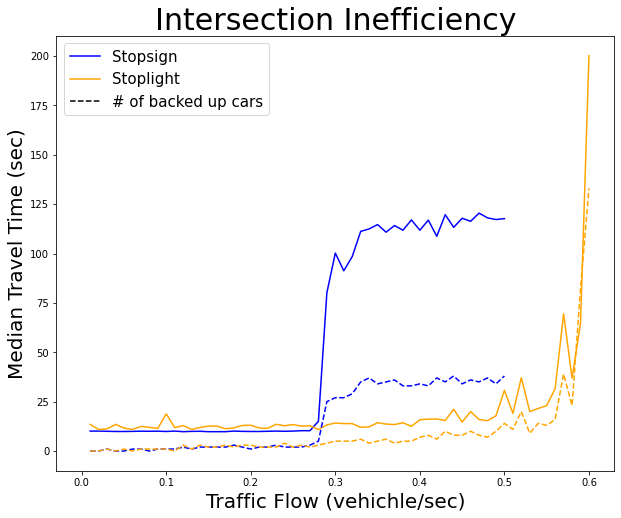

In [71]:
plt.figure(figsize=(10,8))

#plots main lines
plt.plot(sign_medians[:,0][:-10]*10,sign_medians[:,1][:-10], 'b', label="Stopsign")
plt.plot(light_medians[:,0]*10,light_medians[:,1], label="Stoplight", color='orange')

#plots dotted 'backed up cars' lines
plt.plot(sign_extra['Spawn_Chance'][:-10]*10, sign_extra['Extra'][:-10], 'b--')
plt.plot(light_extra['Spawn_Chance']*10, light_extra['Extra'], '--', color='orange')
plt.plot(0, 0, '--', color='black', label='# of backed up cars')

plt.ylabel("Median Travel Time (sec)", size=20)
plt.xlabel("Traffic Flow (vehichle/sec)", size=20)
plt.title("Intersection Inefficiency", size=30)
plt.legend(fontsize=15)
plt.show()

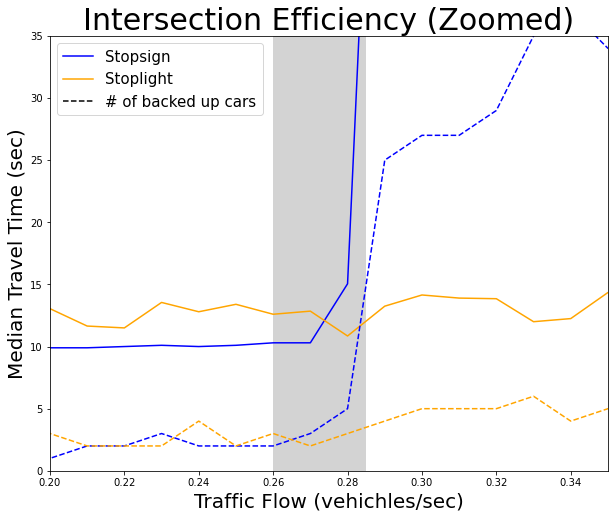

In [51]:
plt.figure(figsize=(10,8))

#plots main lines
plt.plot(sign_medians[:,0][:-10]*10,sign_medians[:,1][:-10], 'b', label="Stopsign")
plt.plot(light_medians[:,0]*10,light_medians[:,1], label="Stoplight", color='orange')

#plots dotted 'backed up cars' lines
plt.plot(sign_extra['Spawn_Chance'][:-10]*10, sign_extra['Extra'][:-10], 'b--')
plt.plot(light_extra['Spawn_Chance']*10, light_extra['Extra'], '--', color='orange')
plt.plot(0, 0, '--', color='black', label='# of backed up cars')

#shows region where the ideal intersection switches
plt.gca().add_patch(plt.Rectangle((.26, 0), .025, 35, fc='lightgrey'))

plt.ylabel("Median Travel Time (sec)", size=20)
plt.xlabel("Traffic Flow (vehichles/sec)", size=20)
plt.title("Intersection Efficiency (Zoomed)", size=30)
plt.legend(fontsize=15)
plt.xlim([.2,.35])
plt.ylim([0,35])
plt.show()

The produced graph shows a clear spike where a stopsign becomes no longer effienct. For the assumptions we made in our model, this change occurs for a traffic flow around .27 vehicles per second. The clear spike of backed up cars with the spike in time can help us draw a conclusion about the nature of this exetreme. We hypothesize that a stopsign has a consistent rate at which they can move traffic through. Right when the incoming traffic flow exceeds this, vehichles will continue to back up more and more.

## Conclusion

Although little validation can be given to our exact numerical assumptions and results, we can conclude that agent-based modeling is a powerful tool for traffic modeling, and our delevoped simulation can produce intriguing visuals and results. Our intuition that a stoplight would eventually become more effienct than a stopsign was beautifully present in our produced data. Furthermore, our project has created a framework for us or others to extend further experimentation and research.